In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, BatchNormalization, Flatten
from keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, Sequence
from sklearn.utils import resample,class_weight, shuffle
from keras.layers import Bidirectional
from IPython.display import clear_output
import matplotlib.patches as mpatches
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import max_norm

Using TensorFlow backend.


In [2]:
#Statistical analysis of the physical properties of the 20 naturally occurring amino acids
def AminoAcidsEmb(string):
    AA_as10Factor= {
      'A' :[-0.591,-1.302,-0.733,1.570,-0.146],
      'R' :[1.538,-0.055,1.502,0.440,2.897],
      'N' :[0.945,0.828,1.299,-0.169,0.933],
      'D' :[1.050,0.302,-3.656,-0.259,-3.242],
      'C' :[-1.343,0.465,-0.862,-1.020,-0.255],
      'Q' :[0.931,-0.179,-3.005,-0.503,-1.853],
      'E' :[1.357,-1.453,1.477,0.113,-0.837],
      'G' :[-0.384,1.652,1.330,1.045,2.064],
      'H' :[0.336,-0.417,-1.673,-1.474,-0.078],
      'I' :[-1.239,-0.547,2.131,0.393,0.816],
      'L' :[-1.019,-0.987,-1.505,1.266,-0.912],
      'K' :[1.831,-0.561,0.533,-0.277,1.648],
      'M' :[-0.663,-1.524,2.219,-1.005,1.212],
      'F' :[-1.006,-0.590,1.891,-0.397,0.412],
      'P' :[0.189,2.081,-1.628,0.421,-1.392],
      'S' :[-0.228,1.399,-4.760,0.670,-2.647],
      'T' :[-0.032,0.326,2.213,0.908,1.313],
      'W' :[-0.595,0.009,0.672,-2.128,-0.184],
      'Y' :[0.260,0.830,3.097,-0.838,1.512],
      'V' :[-1.337,-0.279,-0.544,1.242,-1.262],
      'X' :[0.0]*5,
      '_' :[0.0]*5}
    ls=[]*5
    for item in string:
        if item in AA_as10Factor.keys():
            ls = ls+AA_as10Factor.get(item)
    embedding=np.reshape(np.array(ls),(-1,5))
    return embedding
#(size of protein, dimensions or 21)

def Strings2Embed(array):
    arr = []
    for n in range(array.shape[0]): 
        arr.append(AminoAcidsEmb(array[n]).T)
    arr=np.dstack(arr).T
    return arr

def BLOSUMSIM(string):
    #Obtain the BLOSUM62 Matrix
    string = list(string)
    if len(string)>1:
        num=np.random.randint(0,len(string)-1)
        char=string[num]
    else:
        char = string[0]
        num = 0
    with open("/Volumes/Maxtor/References/blosum62.txt") as matrix_file:
        matrix = matrix_file.read()
    lines = matrix.strip().split('\n')
    header = lines.pop(0)
    columns = header.split()
    matrix = {}
    for row in lines:
        entries = row.split()
        row_name = entries.pop(0)
        matrix[row_name] = {}
        if len(entries) != len(columns):
            raise Exception('Improper entry number in row')
        for column_name in columns:
            matrix[row_name][column_name] = int(entries.pop(0))
    #Retrieve the aa with highest similarity
    listaas = dict(map(reversed, matrix.get(char).items()))
    listprob = np.array(list(listaas.keys()))
    listprob = listprob[np.where(listprob>0)]
    prob = 1
    if listprob[1:].size > 0:
        nn = int(np.random.choice(listprob[1:],1))
        chrf = listaas.get(nn)
        prob = (np.exp(nn))/(sum(np.exp(listprob)))
    else:
        chrf = char
    string[num] = chrf
    string = "".join(string)
    return string, prob

In [3]:
data=pd.read_csv("/Volumes/Maxtor/fakeproteins/fakeresmerge2.csv",delimiter=",")
#data=pd.read_csv("/Users/carloswertcarvajal/Downloads/firsttraintrain5.csv",delimiter=",")
init=data['peptides'].values
c=0
for word in init:
    init[c]=word[0:9]
    c+=1
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(init)

y = np.asarray(data['NB'])
x = to_categorical(np.asarray(tokenizer.texts_to_sequences(init)),num_classes=22)
#y=to_categorical(np.asarray(data['NB']))
#x_train=to_categorical(x,num_classes=22)
#x = Strings2Embed(init)
#x=np.asarray(init)
#y_train=np.asarray(data['NB'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
#x_test=Strings2Embed(x_test)

In [5]:
class BalancedSequence(Sequence):
    """Balancing input classes with augmentation possibility and setting the balancing fraction
    """
    def __init__(self, X, y, batch_size, fracPos=0.5,val_split=0.1,isaug=False,naug=3,p_aug=0.5):
        self.X = X[0:int((1-val_split)*X.shape[0])]
        self.y = y[0:int((1-val_split)*y.shape[0])]
        self.batch_size = batch_size
        self.isaug = isaug
        self.naug = naug
        self.p_aug = p_aug
        self.pos_indices = np.where(self.y == 1)[0]
        self.neg_indices = np.where(self.y == 0)[0]
        self.X_Pos = self.X[self.pos_indices]
        self.n = min(len(self.pos_indices), len(self.neg_indices))
        if fracPos>(len(self.pos_indices)/(len(self.pos_indices)+len(self.neg_indices))):
            self.fracPos = fracPos
        else:
            self.fracPos = len(self.pos_indices)/(len(self.pos_indices)+len(self.neg_indices))
        self._index_array = None

    def __len__(self):
        # Reset batch after we are done with minority class.
        return int((self.n * (1/self.fracPos)) // self.batch_size)

    def on_epoch_end(self):
        # Reset batch after all minority indices are covered.
        self._index_array = None

    def __getitem__(self, batch_idx):
        if self._index_array is None:
            pos_indices = self.pos_indices.copy()
            neg_indices = self.neg_indices.copy()
            np.random.shuffle(pos_indices)
            np.random.shuffle(neg_indices)
            n_neg = int(np.floor(self.n*((1/self.fracPos)-1)))
            self._index_array = np.concatenate((pos_indices[:self.n], neg_indices[:n_neg]))
            np.random.shuffle(self._index_array)
        indices = self._index_array[batch_idx * self.batch_size: (batch_idx + 1) * self.batch_size]
        Xf = self.X[indices]
        Yf = self.y[indices]
        if self.isaug:
            for n in range(0,self.naug):
                new_pep, pp = BLOSUMSIM(self.X_Pos[np.random.randint(0,self.X_Pos.shape[0])])
                Xf = np.append(Xf,new_pep)
                if pp>=self.p_aug:
                    Yf = np.append(Yf,1)
                else:
                    Yf = np.append(Yf,0)
            indexx = np.arange(Xf.shape[0])
            np.random.shuffle(indexx)
            Xf = Xf[indexx]
            Yf = Yf[indexx]
        else:
            pass
        return to_categorical(np.asarray(tokenizer.texts_to_sequences(Xf)),num_classes=22), Yf

class ValidationSet(Sequence):
    def __init__(self,X,y,val_split=0.1):
        self.X = X[-int(val_split*X.shape[0]):]
        self.y = y[-int(val_split*y.shape[0]):]
        self.valToTake = int(val_split*X.shape[0])
    def __len__(self):
        return self.valToTake

    def __getitem__(self,batch_idx):
        return to_categorical(np.asarray(tokenizer.texts_to_sequences(self.X)),num_classes=22),self.y
    
    def on_epoch_end(self):
        pass

class CollectOutputAndTarget(Callback):
    def __init__(self):
        super(CollectOutputAndTarget, self).__init__()
        self.targets = []  # collect y_true batches
        self.outputs = []  # collect y_pred batches
        self.inputs= []

        # the shape of these 2 variables will change according to batch shape
        # to handle the "last batch", specify `validate_shape=False`
        self.var_y_true = tf.Variable(0., validate_shape=False)
        self.var_y_pred = tf.Variable(0., validate_shape=False)
        self.var_x = tf.Variable(0., validate_shape=False)

    def on_batch_end(self, batch, logs=None):
        # evaluate the variables and save them into lists
        self.targets.append(K.eval(self.var_y_true))
        self.outputs.append(K.eval(self.var_y_pred))
        if len(self.inputs)>1:
            print(np.array_equal(self.inputs[-1],self.validation_data[0]))
        self.inputs.append(self.validation_data[0])
        
class AccLossPlotter(Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 
    The graph is updated by the 'on_epoch_end' event of the Keras Callback class
    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 
    """

    def __init__(self, graphs=['acc', 'loss'], save_graph=True):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph


    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            #plt.axis([0,100,0,5])
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')
plot_losses = AccLossPlotter()

Instructions for updating:
Use tf.cast instead.
Train on 2211 samples, validate on 246 samples
Epoch 1/5
2211/2211 [==============================] - 3s 1ms/step - loss: 0.1219 - acc: 0.9575 - val_loss: 0.0242 - val_acc: 0.9878


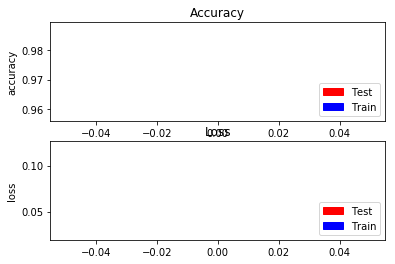

Epoch 2/5
2211/2211 [==============================] - 2s 793us/step - loss: 0.0202 - acc: 0.9937 - val_loss: 0.0048 - val_acc: 1.0000


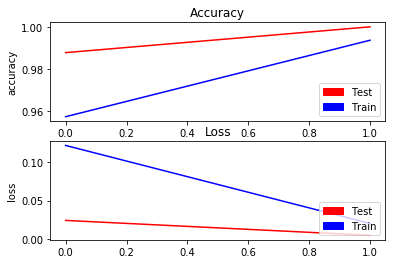

Epoch 3/5
2211/2211 [==============================] - 2s 808us/step - loss: 0.0113 - acc: 0.9964 - val_loss: 0.0224 - val_acc: 0.9919


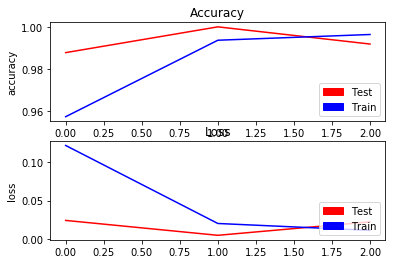

Epoch 4/5
2211/2211 [==============================] - 2s 784us/step - loss: 0.0049 - acc: 0.9986 - val_loss: 0.0024 - val_acc: 1.0000


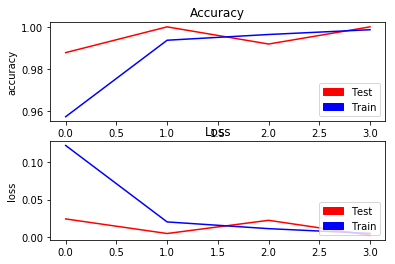

Epoch 5/5
2211/2211 [==============================] - 2s 796us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0042 - val_acc: 1.0000


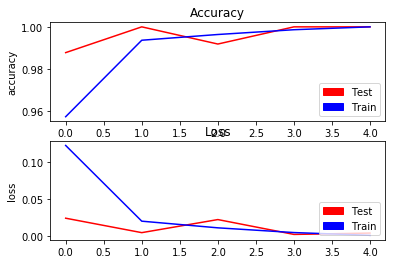

615/615 [==============================] - 0s 149us/step


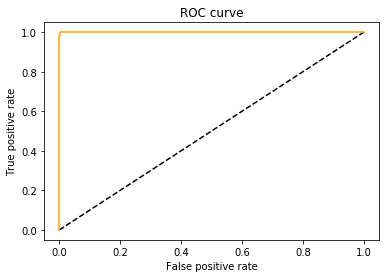

<Figure size 432x288 with 0 Axes>

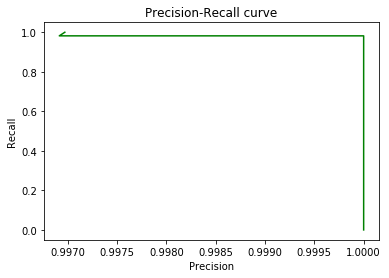

TN 285 FP 1 FN 4 TP 325
AUC: 0.9999362339787872
[0.013531884949092332, 0.9918699167608246]
Precision: 0.9969325153374233
Sensitivity: 0.9878419452887538
Specificity: 0.9965034965034965
Accuracy: 0.991869918699187
F-1: 0.9923664122137404
Train on 2211 samples, validate on 246 samples
Epoch 1/5
2211/2211 [==============================] - 3s 1ms/step - loss: 0.1268 - acc: 0.9462 - val_loss: 0.0489 - val_acc: 0.9797


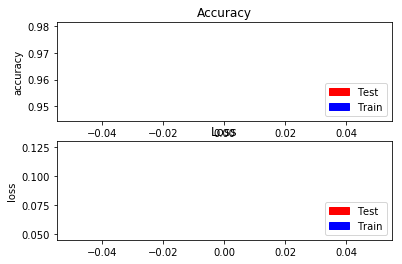

Epoch 2/5
1990/2211 [==========================>...] - ETA: 0s - loss: 0.0248 - acc: 0.9915

KeyboardInterrupt: 

In [6]:
for nn in [5,10,20]:
    model = Sequential()
    model.add(Bidirectional(LSTM(10,return_sequences=True),input_shape=(9,22)))
    #model.add(Bidirectional(LSTM(5,return_sequences=True),input_shape=(9,10)))
    #model.add(Bidirectional(LSTM(5,return_sequences=False),input_shape=(9,5)))
    #model.add(Dense(15, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(nn, activation='relu',input_shape=(9,22)))
    #model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(lr=0.01, epsilon=None, decay=0.0, amsgrad=False)
    BATCH_SIZE=10
    VAL_SPLIT=0.1
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    callbacks_list = [plot_losses]
    model.fit(x_train, y_train, batch_size=10, epochs=5,validation_split=0.1,callbacks=callbacks_list)
    #model.fit_generator(BalancedSequence(init,y_train,BATCH_SIZE,fracPos=0.4,val_split=VAL_SPLIT,isaug=True,naug=1,p_aug=0), validation_data=ValidationSet(x_train,y_train,val_split=VAL_SPLIT), 
    #                   callbacks=callbacks_list, epochs=100)
    score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    y_pred1=model.predict(x_test,batch_size=10)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred1)
    precision, recall, _=precision_recall_curve(y_test, y_pred1)
    auc_keras = auc(fpr_keras, tpr_keras)
    score1 = model.evaluate(x_test, y_test, batch_size=10)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras,color="orange")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.show()
    plt.savefig('jejejej.eps', format='eps', dpi=1000)
    plt.figure(2)
    plt.plot(precision, recall, label='P-R curve',color="green")
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall curve')
    plt.savefig('jejejej2.eps', format='eps', dpi=1000)
    plt.show()
    y_pred1=np.round(y_pred1.ravel(),decimals=0)
    tn, fp, fn, tp=confusion_matrix(y_test,y_pred1, labels=None, sample_weight=None).ravel()
    print('TN',tn,'FP', fp,'FN', fn,'TP', tp)
    print('AUC:',auc_keras)
    print(score1)
    print('Precision:',(tp)/(tp+fp))
    print('Sensitivity:',(tp)/(tp+fn))
    print('Specificity:',(tn)/(fp+tn))
    print('Accuracy:',(tp+tn)/(tp+tn+fp+fn))
    print('F-1:',((tp)/(tp+fp))*2*((tp)/(tp+fn))/(((tp)/(tp+fn))+((tp)/(tp+fp))))

615/615 [==============================] - 0s 324us/step


No handles with labels found to put in legend.


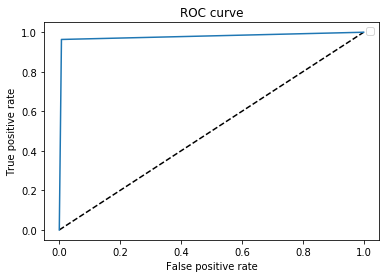

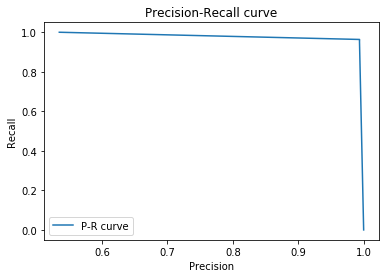

TN 284 FP 2 FN 15 TP 314
AUC: 0.9782239037558186
[0.42548626313998333, 0.9723577198943472]
Precision: 0.9936708860759493
Sensitivity: 0.9544072948328267
Specificity: 0.993006993006993
F-1: 0.9736434108527131


In [18]:
#data1=pd.read_csv("/Volumes/Maxtor/firstrain.csv",delimiter=",")
#init2=data1['peptides'].values
#c=0
#for word in init2:
#   init2[c]=word[0:9]
#   c+=1
#x= np.asarray(tokenizer.texts_to_sequences(init))
#x_test=to_categorical(x,num_classes=22)
#x_1=Strings2Embed(init2)
#print(x_1.shape)
#y_test=to_categorical(np.asarray(data['NB']))
#y_1=np.asarray(data1['NB'])
#print(y_1.shape)

y_pred1=model.predict(x_test,batch_size=10)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred1)
precision, recall, _=precision_recall_curve(y_test, y_pred1)
auc_keras = auc(fpr_keras, tpr_keras)
score1 = model.evaluate(x_test, y_test, batch_size=10)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.figure(2)
plt.plot(precision, recall, label='P-R curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()
y_pred1=np.round(y_pred1.ravel(),decimals=0)
tn, fp, fn, tp=confusion_matrix(y_test,y_pred1, labels=None, sample_weight=None).ravel()
print('TN',tn,'FP', fp,'FN', fn,'TP', tp)
print('AUC:',auc_keras)
print(score1)
print('Precision:',(tp)/(tp+fp))
print('Sensitivity:',(tp)/(tp+fn))
print('Specificity:',(tn)/(fp+tn))
print('F-1:',((tp)/(tp+fp))*2*((tp)/(tp+fn))/(((tp)/(tp+fn))+((tp)/(tp+fp))))

In [ ]:
model.fit_generator(BalancingSequence(x_train,y_train,BATCH_SIZE,fracBal=0.5,isTrain=True),epochs=100)

class BalancingSequence(Sequence):
    def __init__(self,X,y,batch_size,fracBal=0.5,isTrain=True,val_split=0.1):
        self.X = X
        self.y = y
        self.isTrain = isTrain
        self.batch_size = batch_size
        self.pos_indices = np.where(y == 1)[0]
        self.neg_indices = np.where(y == 0)[0]
        self._index_array = None
        self.fracBal = fracBal
        self.val_split = val_split
        self.posToTake = int(self.fracBal*self.batch_size)
        self.negToTake = self.batch_size-self.posToTake
        self.valToTake = int(self.val_split*self.batch_size)

    def __len__(self):
        if self.isTrain:
            return (self.posToTake+self.negToTake) // self.batch_size
        else:
            return self.valToTake // self.batch_size
        
    def __get__elem__balanced(self,batch_idx):
        posElemts = self.pos_indices[batch_idx : batch_idx+self.posToTake]
        negElemts = np.random.choice(self.neg_indices, self.negToTake, replace=False)
        np.random.seed(batch_idx)
        self._index_array = np.concatenate([posElemts, negElemts])
        np.random.shuffle(self._index_array)
        np.random.seed(None)
        indices = self._index_array[batch_idx * self.batch_size: (batch_idx + 1) * self.batch_size]
        print(self.X[indices,:,:].shape)
        return self.X[indices,:,:],self.y[indices]
    
    def __get__elem__val(self):
        all_indices = np.concatenate([self.pos_indices, self.neg_indices])
        np.random.seed(len(all_indices))
        selElemts = np.random.choice(all_indices, self.valToTake, replace=False)
        x = self.X[selElemts,:,:]
        y = self.y[selElemts]
        return x,y
    
    def on_epoch_end(self):
        self._index_array = None
    
    def __getitem__(self, batch_idx):
        if self.isTrain:
            return self.__get__elem__balanced(batch_idx)
        else:
            return self.__get__elem__val()

In [ ]:
x_train=Strings2Embed(x_train)
model = Sequential()
model.add(Bidirectional(LSTM(10, kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3))))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
adam = Adam(lr=0.01, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#filepath="weights.best.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#Insert checkpoint below
callbacks_list = [plot_losses]
history=model.fit(x_train, y_train, batch_size=10, epochs=100,validation_split=0.1,callbacks=callbacks_list,class_weight=class_weights)
#model.fit_generator(BalancedSequence(x_train,y_train,batch_size=10), epochs=100)
score = model.evaluate(x_test, y_test, batch_size=10)
y_pred=model.predict(x_test,batch_size=10)

In [ ]:
print(init)

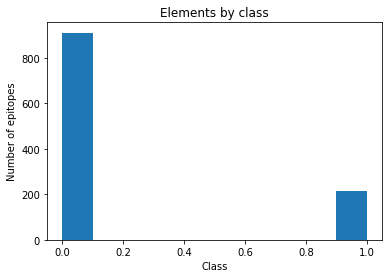

In [24]:
plt.hist(y)
plt.xlabel('Class')
plt.ylabel('Number of epitopes')
plt.title('Elements by class')
plt.savefig('jejejej3.eps', format='eps', dpi=1000)

In [13]:
print(len(y==1))
print(len(y==0))

3072
3072


In [28]:
print(len(y[y==1])/len(y))

0.1895017793594306


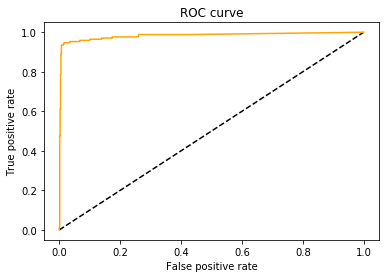

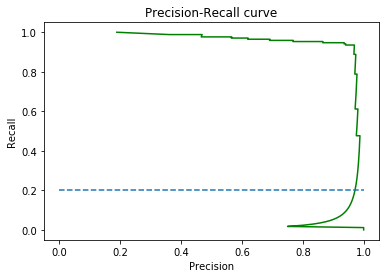

In [11]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras,color="orange")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig('jejejej.eps', format='eps', dpi=1000)
plt.show()
plt.figure(2)
plt.plot(precision, recall, label='P-R curve',color="green")
plt.plot([0, 1], [0.2, 0.2], linestyle='--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve')
plt.savefig('jejejej2.eps', format='eps', dpi=1000)
plt.show()

In [30]:
from keras.utils import plot_model
plot_model(model, to_file='toymodelfinal.png')

In [9]:
print(x_train.shape)

(2457, 9, 22)
